This example requires the following dependencies to be installed:
pip install lightly[timm]

In [1]:
!pip install lightly[timm]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Note: The model and training settings do not follow the reference settings
# from the paper. The settings are chosen such that the example can easily be
# run on a small dataset with a single GPU.
import torch
import torchvision
from timm.models.vision_transformer import vit_base_patch32_224
from torch import nn

In [3]:
from lightly.models import utils
from lightly.models.modules import MAEDecoderTIMM, MaskedVisionTransformerTIMM
from lightly.transforms import MAETransform

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [4]:
class MAE(nn.Module):
    def __init__(self, vit):
        super().__init__()

        decoder_dim = 512
        self.mask_ratio = 0.75
        self.patch_size = vit.patch_embed.patch_size[0]

        self.backbone = MaskedVisionTransformerTIMM(vit=vit)
        self.sequence_length = self.backbone.sequence_length
        self.decoder = MAEDecoderTIMM(
            num_patches=vit.patch_embed.num_patches,
            patch_size=self.patch_size,
            embed_dim=vit.embed_dim,
            decoder_embed_dim=decoder_dim,
            decoder_depth=1,
            decoder_num_heads=16,
            mlp_ratio=4.0,
            proj_drop_rate=0.0,
            attn_drop_rate=0.0,
        )

    def forward_encoder(self, images, idx_keep=None):
        return self.backbone.encode(images=images, idx_keep=idx_keep)

    def forward_decoder(self, x_encoded, idx_keep, idx_mask):
        # build decoder input
        batch_size = x_encoded.shape[0]
        x_decode = self.decoder.embed(x_encoded)
        x_masked = utils.repeat_token(
            self.decoder.mask_token, (batch_size, self.sequence_length)
        )
        x_masked = utils.set_at_index(x_masked, idx_keep, x_decode.type_as(x_masked))

        # decoder forward pass
        x_decoded = self.decoder.decode(x_masked)

        # predict pixel values for masked tokens
        x_pred = utils.get_at_index(x_decoded, idx_mask)
        x_pred = self.decoder.predict(x_pred)
        return x_pred

    def forward(self, images):
        batch_size = images.shape[0]
        idx_keep, idx_mask = utils.random_token_mask(
            size=(batch_size, self.sequence_length),
            mask_ratio=self.mask_ratio,
            device=images.device,
        )
        x_encoded = self.forward_encoder(images=images, idx_keep=idx_keep)
        x_pred = self.forward_decoder(
            x_encoded=x_encoded, idx_keep=idx_keep, idx_mask=idx_mask
        )

        # get image patches for masked tokens
        patches = utils.patchify(images, self.patch_size)
        # must adjust idx_mask for missing class token
        target = utils.get_at_index(patches, idx_mask - 1)
        return x_pred, target

In [5]:
vit = vit_base_patch32_224()
model = MAE(vit)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

MAE(
  (backbone): MaskedVisionTransformerTIMM(
    (vit): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_featu

In [7]:
transform = MAETransform()
# we ignore object detection annotations by setting target_transform to return 0

In [8]:
def target_transform(t):
    return 0

In [17]:
model.sequence_length

50

Image shape: torch.Size([1, 3, 128, 128])


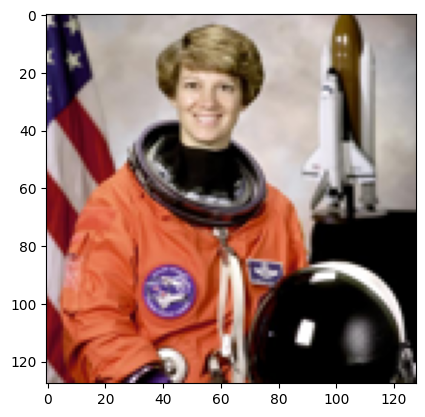

In [31]:
# prompt: get one person image of size 128x128

from PIL import Image
import requests
from io import BytesIO

url = "https://raw.githubusercontent.com/pytorch/vision/main/gallery/assets/astronaut.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

# Resize the image to 128x128
img_resized = img.resize((128, 128))

# Convert to tensor and add batch dimension
from torchvision.transforms import ToTensor
image = ToTensor()(img_resized).unsqueeze(0)

print(f"Image shape: {image.shape}")

plt.imshow(img_resized)
plt.show()


In [28]:
# check model
model.patch_size


import numpy as np

images = image.to(device)

images.shape
patches = utils.patchify(images, model.patch_size) #(1,16,3072)

len(patches)

1

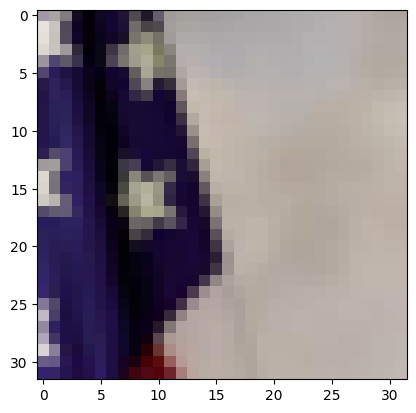

(<matplotlib.image.AxesImage at 0x7e162e53ead0>, None)

In [29]:
# patches.shape
from matplotlib import pyplot as plt

img1 = patches[0,0,:].reshape(32,32,3)

plt.imshow(img1.cpu().numpy()),plt.show()


In [32]:
pred = model(images)

AssertionError: Input height (128) doesn't match model (224).

In [ ]:
dataset = torchvision.datasets.VOCDetection(
    "datasets/pascal_voc",
    download=True,
    transform=transform,
    target_transform=target_transform,
)
# or create a dataset from a folder containing images or videos:
# dataset = LightlyDataset("path/to/folder")

In [ ]:
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    shuffle=True,
    drop_last=True,
    num_workers=8,
)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1.5e-4)

In [ ]:
print("Starting Training")
for epoch in range(10):
    total_loss = 0
    for batch in dataloader:
        views = batch[0]
        images = views[0].to(device)  # views contains only a single view
        predictions, targets = model(images)
        loss = criterion(predictions, targets)
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = total_loss / len(dataloader)
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")